In [1]:
import cloudViewer as cv3d
import numpy as np
import copy
import os
import sys

# monkey patches visualization and provides helpers to load geometries
sys.path.append('../..')
import cloudViewer_tutorial as cv3dtut
# change to True if you want to interact with the visualization windows
cv3dtut.interactive = not "CI" in os.environ

Jupyter environment detected. Enabling CloudViewer WebVisualizer.
[CloudViewer INFO] WebRTC GUI backend enabled.
[CloudViewer INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[download_utils.py] /media/asher/data/pcl_projects/ErowCloudViewer/ErowCloudViewerPython/test_data/cloudViewer_downloads/RGBD/raycast_vtx_004.npy already exists, skipped.
[download_utils.py] /media/asher/data/pcl_projects/ErowCloudViewer/ErowCloudViewerPython/test_data/cloudViewer_downloads/RGBD/normal_map.npy already exists, skipped.
[download_utils.py] /media/asher/data/pcl_projects/ErowCloudViewer/ErowCloudViewerPython/test_data/cloudViewer_downloads/tests/bunnyData.pts already exists, skipped.
[download_utils.py] /media/asher/data/pcl_projects/ErowCloudViewer/ErowCloudViewerPython/test_data/cloudViewer_downloads/tests/point_cloud_sample1.pts already exists, skipped.
[download_utils.py] /media/asher/data/pcl_projects/ErowCloudViewer/ErowCloudViewerPython/test_data/cloudViewer_downloads/tests/point_clou

# Robust kernels

This tutorial demonstrates the use of robust kernels in the context of outlier rejection. For this particular tutorial, we will be using the ICP (Iterative Closest Point) registration algorithm as the _target_ problem where we want to deal with outliers. Even so, the theory applies to any given optimization problem and not just for ICP. For the moment the robust kernels have been only implemented for the `PointToPlane` ICP.

The notation and some of the kernels implemented in `CloudViewer` has been inspired by the publication "Analysis of Robust Functions for Registration Algorithms" [\[Babin2019\]](../reference.html#babin2019)

<div class="alert alert-info">
 
**Note:** 

This tutorial and the original implementation of the robust kernels in `CloudViewer` was contributed by **Ignacio Vizzo** and **Cyrill Stachniss** from the University of Bonn.

</div>

## Input Data

The code below reads a source point cloud and a target point cloud from two files. A rough transformation is given.

<div class="alert alert-info">
    
**Note:** 

The initial alignment is usually obtained by a global registration algorithm. See [Global registration](../pipelines/global_registration.rst) for examples.

</div>

In [2]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    cv3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

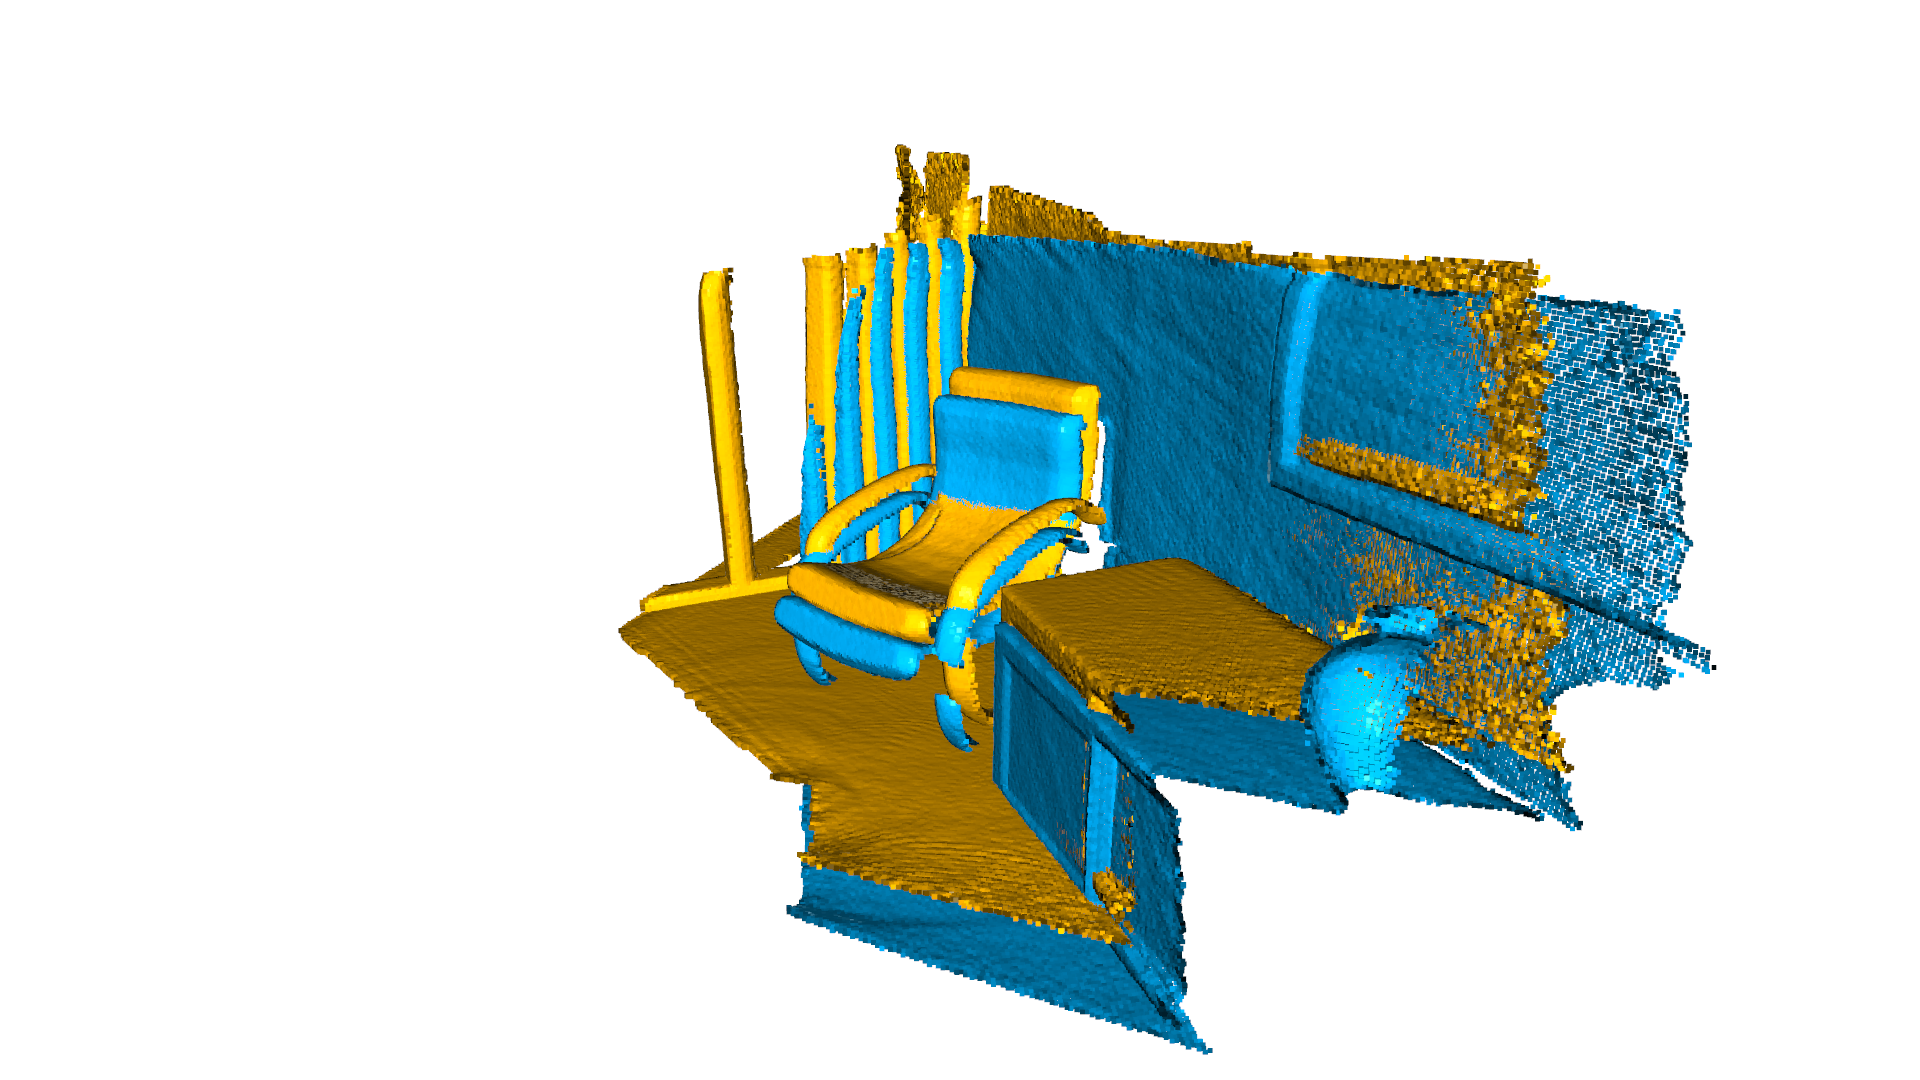

In [3]:
source = cv3d.io.read_point_cloud("../../../test_data/ICP/cloud_bin_0.pcd")
target = cv3d.io.read_point_cloud("../../../test_data/ICP/cloud_bin_1.pcd")
trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(source, target, trans_init)

## Point-to-plane ICP using Robust Kernels

The standard point-to-plane ICP algorithm [\[ChenAndMedioni1992\]](../reference.html#chenandmedioni1992) minimizes this objective function:

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\big((\mathbf{p} - \mathbf{T}\mathbf{q})\cdot\mathbf{n}_{\mathbf{p}}\big)^{2},
\end{equation}

where $\mathbf{n}_{\mathbf{p}}$ is the normal of point $\mathbf{p}$ and $\mathcal{K}$ is the correspondence set between the target point cloud $\mathbf{P}$, and source point cloud $\mathbf{Q}$.

If we call $r_i(\mathbf{T})$ is $i^\mathrm{th}$ the residual, for a given pair of correspondences $(\mathbf{p},\mathbf{q})\in\mathcal{K}$ we can rewrite the objective function as.

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\big((\mathbf{p} - \mathbf{T}\mathbf{q})\cdot\mathbf{n}_{\mathbf{p}}\big)^{2} = \sum_{i=1}^{N} \big({r_i(\mathbf{T})}\big)^2
\end{equation}

The optimization problem above can also be solved by using the iteratively reweighted least-squares (IRLS) approach, which solves a sequence of weighted least squares problems:

\begin{equation}
E(\mathbf{T}) =  \sum_{i=1}^{N} w_i \big({r_i(\mathbf{T})}\big)^2
\end{equation}

### Outlier Rejection with Robust Kernels

The main idea of a robust loss is to downweight large residuals that are assumed to be caused from outliers such that their influence on the solution is reduced. This is achieved by optimizing $E(\mathbf{T})$ as:

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\rho\big((\mathbf{p} - \mathbf{T}\mathbf{q})\cdot\mathbf{n}_{\mathbf{p}}\big) = \sum_{i=1}^{N} \rho\big({r_i(\mathbf{T})}\big),
\end{equation}

where $\rho(r)$ is also called the robust loss or kernel.

We can see that exists a relation between the optimization formulation in IRLS and the one that uses the robust loss function. By setting the weight $w_i= \frac{1}{r_i(\mathbf{T})}\rho'(r_i(\mathbf{T}))$, we can solve the robust loss optimization problem using the existing techniques for weighted least-squares. Therefore, we can minimize the objective function using Gauss-Newton and determine increments by iteratively solving:

\begin{align}
\left(\mathbf{J}^\top \mathbf{W} \mathbf{J}\right)^{-1}\mathbf{J}^\top\mathbf{W}\vec{r},
\end{align}

where $\mathbf{W} \in \mathbb{R}^{N\times N}$ is a diagonal matrix containing weights $w_i$ for each residual $r_i$

### How to use Robust Kernels in CloudViewer

`registration_icp` can be called with a parameter `TransformationEstimationPointToPlane(loss)`. Where `loss` is a given loss function(also called robust kernel). 

Internally, `TransormationEstimationPointToPlane(loss)` implements a function to compute the weighted residuals and Jacobian matrices of the point-to-plane ICP objective according to the provided robust kernel.

<div class="alert alert-info">
 
**Note:** 

For more details on the ICP algorithm please see [ICP Registration](../pipelines/icp_registration.rst).

</div>

## Vanilla ICP vs Robust ICP

To better show the advantages of using robust kernels in the registration, we add some artificially generated gaussian noise to the source point cloud.

Source PointCloud + noise:


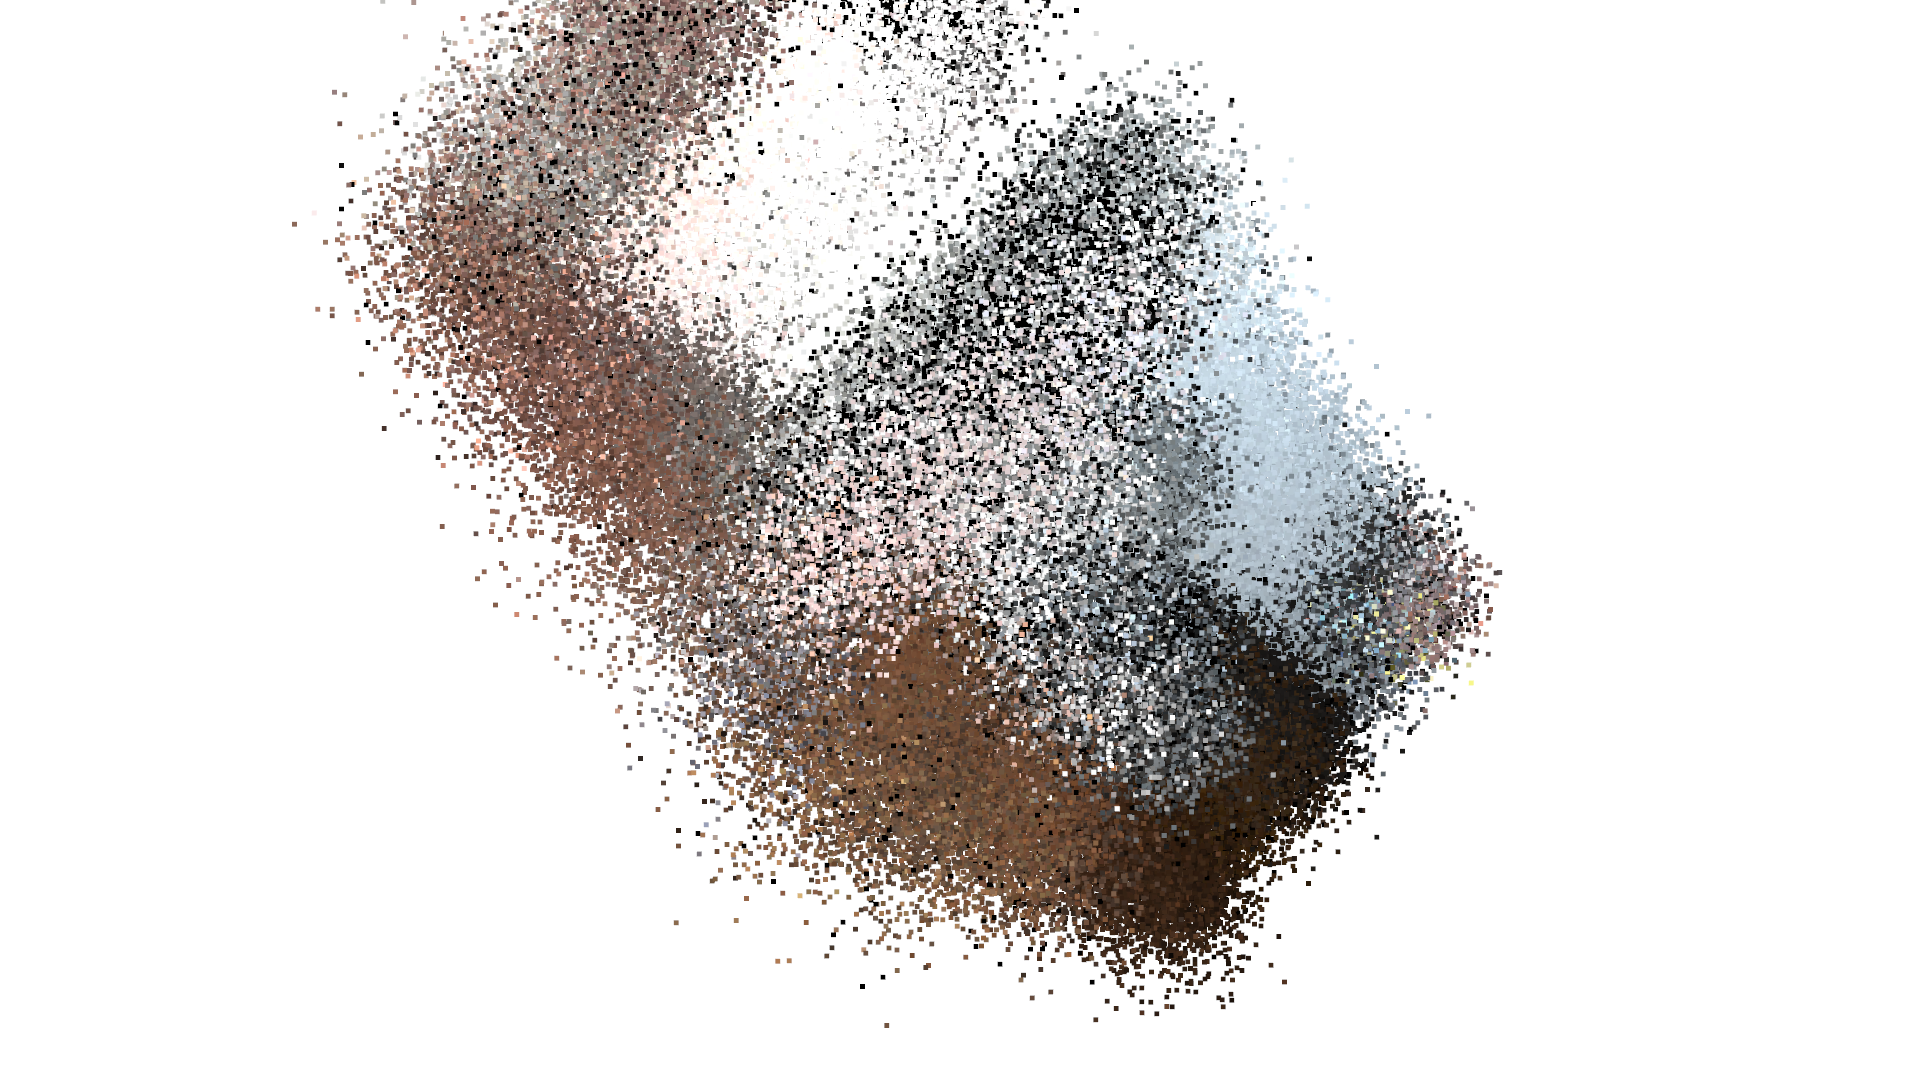

In [4]:
def apply_noise(pcd, mu, sigma):
    noisy_pcd = copy.deepcopy(pcd)
    points = np.asarray(noisy_pcd.get_points())
    points += np.random.normal(mu, sigma, size=points.shape)
    noisy_pcd.set_points(cv3d.utility.Vector3dVector(points))
    return noisy_pcd


mu, sigma = 0, 0.1  # mean and standard deviation
source_noisy = apply_noise(source, mu, sigma)

print("Source PointCloud + noise:")
cv3d.visualization.draw_geometries([source_noisy],
                                  zoom=0.4459,
                                  front=[0.353, -0.469, -0.809],
                                  lookat=[2.343, 2.217, 1.809],
                                  up=[-0.097, -0.879, 0.467])

### Vanilla ICP

We inspect how the results will look if we use the exact same parameters that were used in the [ICP Registration Tutorial](../pipelines/icp_registration.rst).

In [ ]:
threshold = 0.02
print("Vanilla point-to-plane ICP, threshold={}:".format(threshold))
p2l = cv3d.pipelines.registration.TransformationEstimationPointToPlane()
reg_p2l = cv3d.pipelines.registration.registration_icp(source_noisy, target,
                                                      threshold, trans_init,
                                                      p2l)

print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
draw_registration_result(source, target, reg_p2l.transformation)

Vanilla point-to-plane ICP, threshold=0.02:


### Tuning Vanilla ICP

Given the fact that we are now dealing with gaussian noise, we might try to increase the threshold to search for nearest neighbors with the aim of improving the registration result.

We can see that under these condtions and without a robust kernel, the traditional ICP has no chance to deal with  outliers.

In [ ]:
threshold = 1.0
print("Vanilla point-to-plane ICP, threshold={}:".format(threshold))
p2l = cv3d.pipelines.registration.TransformationEstimationPointToPlane()
reg_p2l = cv3d.pipelines.registration.registration_icp(source_noisy, target,
                                                      threshold, trans_init,
                                                      p2l)

print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
draw_registration_result(source, target, reg_p2l.transformation)

### Robust ICP

Using the same `threshold=1.0` **and** a robust kernel, we can properly register the two point clouds:

In [ ]:
print("Robust point-to-plane ICP, threshold={}:".format(threshold))
loss = cv3d.pipelines.registration.TukeyLoss(k=sigma)
print("Using robust loss:", loss)
p2l = cv3d.pipelines.registration.TransformationEstimationPointToPlane(loss)
reg_p2l = cv3d.pipelines.registration.registration_icp(source_noisy, target,
                                                      threshold, trans_init,
                                                      p2l)
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
draw_registration_result(source, target, reg_p2l.transformation)

<div class="alert alert-info">
    
**Note:** 

For this example we use the **TukeyLoss**, available in `cloudViewer.pipelines.registration.TukeyLoss`. For the parameter `k` we set it to match the std deviation of the noise model $k = \sigma$.
The parameter `k` used in the Robust Kernels it's usually pick to match the standard deviation of the noise model of the input data. In this sense, `k`, is the discriminator between **inlier**/**outlier**. Altough this is not always trivial to define in real world data, for synthetic one, it's easy to fix in order to illustrate the benefits of the robust kernels.
 
</div>